# Training CNN on Optical Flow features

In [2]:
import subprocess
import platform
import sys

sys.path.append("/home/lnmiit/caffe/python")
import lmdb

from sklearn.cross_validation import StratifiedShuffleSplit
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import caffe
caffe.set_mode_gpu()

/home/lnmiit/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/lnmiit/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/lnmiit/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


## Status Quo

In [4]:
print("OS : "+platform.platform())
print("Python: "+ sys.version.split("\n")[0])
print("CUDA: "+ subprocess.Popen(["nvcc","--version"], stdout=subprocess.PIPE).communicate()[0].split("\n")[3])
print("LMDB: "+".".join([str(i) for i in lmdb.version()]))

OS : Linux-3.16.0-30-generic-x86_64-with-debian-jessie-sid
Python: 2.7.11 |Anaconda custom (64-bit)| (default, Dec  6 2015, 18:08:32) 
CUDA: Cuda compilation tools, release 7.5, V7.5.17
LMDB: 0.9.14


## 1. Load data from the optical flow files and transform into LMDB

## 2 (a) Save to LMDB

In [5]:
# http://deepdish.io/2015/04/28/creating-lmdb-in-python/
def load_data_into_lmdb(lmdb_name, features, labels=None):
    env = lmdb.open(lmdb_name, map_size=features.nbytes*2)
    
    features = features[:,:,None,None]
    for i in range(features.shape[0]):
        datum = caffe.proto.caffe_pb2.Datum()
        
        datum.channels = features.shape[1]
        datum.height = 1
        datum.width = 1
        
        if features.dtype == np.int:
            datum.data = features[i].tostring()
        elif features.dtype == np.float: 
            datum.float_data.extend(features[i].flat)
        else:
            raise Exception("features.dtype unknown.")
        
        if labels is not None:
            datum.label = int(labels[i])
        
        str_id = '{:08}'.format(i)
        with env.begin(write=True) as txn:
            txn.put(str_id, datum.SerializeToString())

## 2 (b). Check content of LMDB

In [6]:
# http://research.beenfrog.com/code/2015/03/28/read-leveldb-lmdb-for-caffe-with-python.html
def get_data_for_id_from_lmdb(lmdb_name, id):
    lmdb_env = lmdb.open(lmdb_name, readonly=True)
    lmdb_txn = lmdb_env.begin()
    
    lmdb_cursor = lmdb_txn.cursor()
    raw_datum = lmdb_txn.get(id)
    datum = caffe.proto.caffe_pb2.Datum()
    datum.ParseFromString(raw_datum)
    
    if(len(datum.data)):
        feature = np.fromstring(datum.data, dtype=float).reshape(datum.channels, datum.height, datum.width)
    label = datum.label
    
    return(label, feature)

In [7]:
# def read_from_lmdb(path, lmdb_dir):
# 	env = lmdb.open(os.path.join(path, lmdb_dir), readonly=True)
# 	with env.begin() as txn:
# 		raw_datum = txn.get(b'00000000')

# 	datum = caffe.proto.caffe_pb2.Datum()
# 	datum.ParseFromString(raw_datum)

# 	flat_x = np.fromstring(datum.data, dtype=np.uint8)
# 	x = flat_x.reshape(datum.channels, datum.height, datum.width)
# 	y = datum.label

# 	# Iterating <key, value> pairs is also easy:

# 	with env.begin() as txn:
# 		cursor = txn.cursor()
# 		for key, value in cursor:
# 			print(key, value)


In [95]:
# Shows error while parsingFromString()
l, f=get_data_for_id_from_lmdb("/home/lnmiit/caffe/examples/optical_flow/val_opt_flow_lmdb/", "00003628")
f1 = f[0,...]
f2 = f[1,...]
print(str(f1.min())+" "+str(f1.max()))
print(np.sum(f2))

-1.7553601265 2.70666313171
12483.2145863


In [9]:
#proc = subprocess.Popen(["/home/lnmiit/caffe/build/tools/caffe","train","--solver=opt_flow_quick_solver.prototxt"],stderr=subprocess.PIPE)
#res = proc.communicate()[1]

# caffe.set_mode_gpu()
# solver = caffe.get_solver("config.prototxt")
# solver.solve()


In [61]:
print res

I0514 14:43:27.154709 17931 caffe.cpp:185] Using GPUs 0
I0514 14:43:27.197549 17931 caffe.cpp:190] GPU 0: GeForce GTX 750
I0514 14:43:27.320962 17931 solver.cpp:48] Initializing solver from parameters: 
test_iter: 191
test_interval: 500
base_lr: 0.001
display: 2000
max_iter: 20000
lr_policy: "fixed"
momentum: 0.9
weight_decay: 0.004
snapshot: 20000
snapshot_prefix: "/home/lnmiit/caffe/examples/optical_flow/opt_flow_quick"
solver_mode: GPU
device_id: 0
net: "/home/lnmiit/caffe/examples/optical_flow/demoDeploy.prototxt"
momentum2: 0.999
type: "Adam"
I0514 14:43:27.321100 17931 solver.cpp:91] Creating training net from net file: /home/lnmiit/caffe/examples/optical_flow/demoDeploy.prototxt
I0514 14:43:27.321591 17931 net.cpp:313] The NetState phase (0) differed from the phase (1) specified by a rule in layer optFlow
I0514 14:43:27.321611 17931 net.cpp:313] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0514 14:43:27.321735 17931 net.cpp:49] Initia

## 3. Applying the model

In [8]:
net = caffe.Net("demoDeploy.prototxt", "./opt_flow_quick_iter_20000.caffemodel", caffe.TEST)
print(get_data_for_id_from_lmdb("/home/lnmiit/caffe/examples/optical_flow/val_opt_flow_lmdb/", "00000209"))
l, f = get_data_for_id_from_lmdb("/home/lnmiit/caffe/examples/optical_flow/val_opt_flow_lmdb/", "00000209")


(3, array([[[ 0.01617447,  0.01880421,  0.01784601, ..., -0.03219811,
         -0.01808405, -0.00618309],
        [ 0.0161554 ,  0.01879297,  0.01520977, ..., -0.04300429,
         -0.02535936, -0.01182795],
        [ 0.01434633,  0.0169968 ,  0.01218427, ..., -0.05296153,
         -0.03483085, -0.01945863],
        ..., 
        [ 0.13786833,  0.22567807,  0.28621793, ..., -0.14797474,
         -0.14543656, -0.10805685],
        [ 0.08082159,  0.13045096,  0.15251046, ..., -0.13118114,
         -0.12829384, -0.08732368],
        [ 0.02808714,  0.05322036,  0.06514895, ..., -0.08539873,
         -0.07943287, -0.04684254]],

       [[ 0.01542514,  0.01939967,  0.01895853, ...,  0.01675299,
          0.01316899,  0.00864298],
        [ 0.01675371,  0.02032766,  0.01881379, ...,  0.01615764,
          0.01284121,  0.00910882],
        [ 0.01603878,  0.01897619,  0.01732814, ...,  0.01344483,
          0.01058616,  0.00776568],
        ..., 
        [-0.00257302,  0.0034742 ,  0.01065132, 

In [10]:
testNet = caffe.Net("/home/lnmiit/caffe/examples/optical_flow/demoDeployTest.prototxt",
                    "/home/lnmiit/caffe/examples/optical_flow/opt_flow_quick_iter_20000.caffemodel",
                   caffe.TEST)
#print(l)

NameError: name 'l' is not defined

In [79]:
#print(net.)
#out = net.forward(**{net.inputs[0]: np.asarray([f])})
#out = net.forward(**{"optFlow": np.asarray([f])})
#l, f = get_data_for_id_from_lmdb("/home/lnmiit/caffe/examples/optical_flow/val_opt_flow_lmdb/", "00000853")
l, f = get_data_for_id_from_lmdb("/home/lnmiit/caffe/examples/optical_flow/val_opt_flow_lmdb/", "00000753")
print(np.asarray([f]).shape)
testNet.blobs["data"].data[...] = np.asarray([f])
out= testNet.forward()
print(dir(testNet))
#print(testNet.layers[1].blobs[1].data)
print("Data:")
print(testNet.blobs['data'].data)
print("Conv1:")
print(testNet.blobs['conv1'].data.shape)
print(testNet.blobs['pool1'].data)
print("Conv2:")
print(testNet.blobs['conv2'].data)
print(testNet.blobs['pool2'].data)
print("Actual Label : "+ str(l))
print("Predicted Class is : #{}.".format(out['fc8'].argmax()))
print(out)

(1, 2, 120, 160)
['__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_backward', '_batch', '_blob_loss_weights', '_blob_names', '_blobs', '_blobs_dict', '_bottom_ids', '_forward', '_input_list', '_inputs', '_layer_names', '_output_list', '_outputs', '_set_input_arrays', '_top_ids', 'backward', 'blob_loss_weights', 'blobs', 'bottom_names', 'copy_from', 'forward', 'forward_all', 'forward_backward_all', 'inputs', 'layers', 'outputs', 'params', 'reshape', 'save', 'set_input_arrays', 'share_with', 'top_names']
Data:
[[[[ -5.53556392e-03  -7.54043926e-03  -8.87326058e-03 ...,
      2.47287680e-03   2.05394463e-03   1.76608749e-03]
   [ -7.02798041e-03  -9.17912833e-03  -1.10543938e-02 ...,
      2.93198531e-03   2.38465355e-03   2.04809965e-03]
   [ -7.21808989e-03  -9.07142647e-03  -1.1222485

In [13]:
print("Predicted Class is : #{}.".format(out['fc8'].argmax()))
print(out['fc8'].shape)
#print(str(np.argmax(out['prob'][0] == l) + "\n" + str(out)))
#plt.bar(range(9), out["prob"][0])
print(l)

Predicted Class is : #3.
(1, 6)
3


## 4. Visualizing the Network Graph

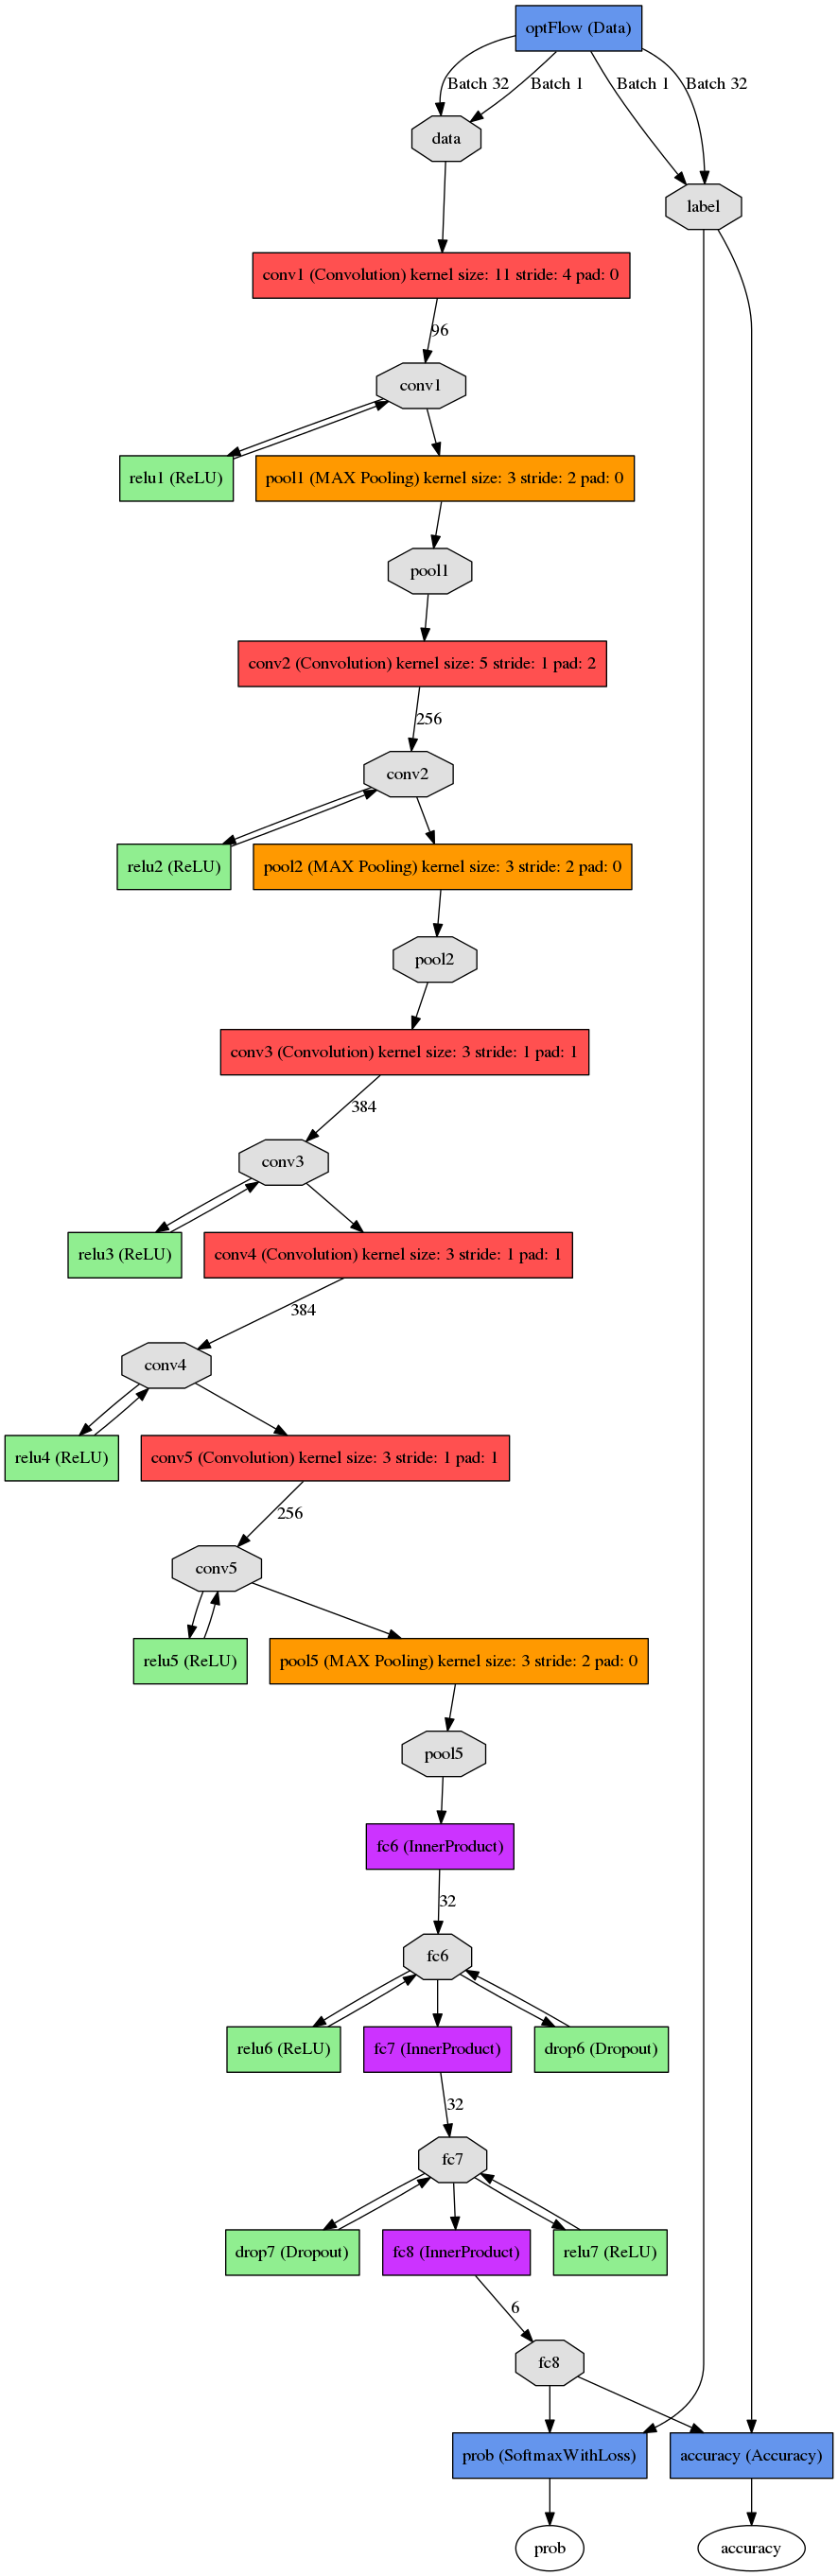

In [17]:
from google.protobuf import text_format
from caffe.draw import get_pydot_graph
from caffe.proto import caffe_pb2
from IPython.display import display, Image 

_net = caffe_pb2.NetParameter()
f = open("demoDeploy.prototxt")
text_format.Merge(f.read(), _net)
display(Image(get_pydot_graph(_net,"TB").create_png()))

## 5. Visualizing the Weights

In [21]:
# weights connecting the input with relu1
arr = net.params["fc6"][0].data
arr

array([[  4.47014300e-37,  -6.98836288e-38,  -5.26088474e-38, ...,
          5.06383022e-40,   4.72583703e-40,   3.90499843e-40],
       [ -2.24290229e-03,  -1.52244908e-03,  -1.38990476e-03, ...,
         -5.37561448e-07,  -7.10412394e-07,  -3.20758154e-05],
       [ -4.65537561e-03,   2.33024545e-03,  -7.28430785e-03, ...,
         -3.45319207e-03,  -4.86599607e-03,  -1.20179344e-03],
       ..., 
       [ -4.57307138e-03,  -8.32582638e-03,  -4.75330325e-03, ...,
         -6.57220045e-03,  -2.69890390e-03,  -1.65398140e-02],
       [ -2.88078474e-04,  -1.41701498e-03,  -2.04202533e-03, ...,
         -4.44266666e-03,  -5.18942624e-03,   1.38533162e-03],
       [ -7.44234547e-38,  -1.68865657e-38,  -1.89175338e-37, ...,
         -1.02450332e-39,  -1.22251240e-39,  -2.39664076e-40]], dtype=float32)

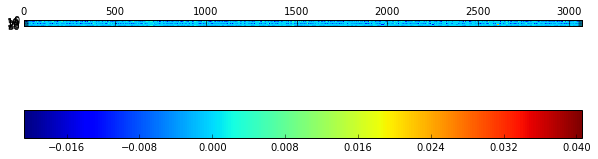

In [26]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(arr, interpolation="none")
fig.colorbar(cax, orientation="horizontal")

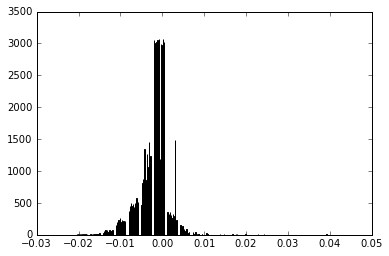

In [27]:
_ = plt.hist(arr.tolist(), bins=20)